In [13]:
# Uses rolling window(with limited data) to make next predictions for efficiency.
# Implements grid search to find the optimum parameters.

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
from itertools import product

# Load dataset
series = pd.read_csv('../dataset/chattahoochee_1hr_02336490.csv', usecols=['DATE', 'gaze_height'], header=0, index_col='DATE', parse_dates=True)[:1000]

# Split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]

# Define the parameter grid
p = d = q = range(0, 2)
pdq = [x for x in product(p, d, q) if  x[0] > 1 and x[1] > 1]
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(product(p, d, q))]

# Grid search function
def grid_search(train_data):
    best_aic = np.inf
    best_params = None
    best_seasonal_params = None
    
    for param in pdq:
        for seasonal_param in seasonal_pdq:
            try:
                model = SARIMAX(train_data, order=param, seasonal_order=seasonal_param)
                results = model.fit(disp=False)
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_params = param
                    best_seasonal_params = seasonal_param
            except:
                continue
    
    return best_params, best_seasonal_params

# Perform initial grid search
print("Performing initial grid search...")
best_params, best_seasonal_params = grid_search(train)

print(f"Best SARIMA parameters: {best_params}")
print(f"Best seasonal parameters: {best_seasonal_params}")


Performing initial grid search...
Best SARIMA parameters: None
Best seasonal parameters: None


In [14]:
pdq

[]

Performing initial grid search...


/Users/cuser/Documents/cybertraining/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/cuser/Documents/cybertraining/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/cuser/Documents/cybertraining/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/cuser/Documents/cybertraining/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum

Best SARIMA parameters: (1, 1, 1)
Best seasonal parameters: (0, 0, 0, 24)
Performing walk-forward validation...


/Users/cuser/Documents/cybertraining/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Re-evaluating parameters at step 168


/Users/cuser/Documents/cybertraining/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/cuser/Documents/cybertraining/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/cuser/Documents/cybertraining/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/cuser/Documents/cybertraining/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihoo

Updated best SARIMA parameters: (1, 1, 1)
Updated best seasonal parameters: (0, 0, 0, 24)


/Users/cuser/Documents/cybertraining/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/cuser/Documents/cybertraining/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/cuser/Documents/cybertraining/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Re-evaluating parameters at step 336


/Users/cuser/Documents/cybertraining/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Updated best SARIMA parameters: (1, 1, 1)
Updated best seasonal parameters: (0, 0, 0, 24)
Test RMSE: 0.107


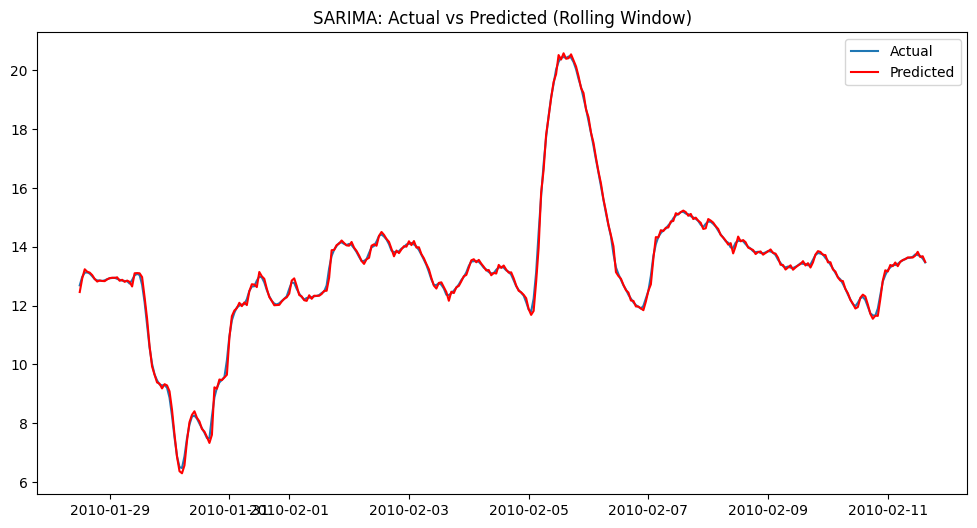

In [4]:


# Walk-forward validation with rolling window
window_size = 168  # One week of hourly data
history = train[-window_size:]
predictions = []

print("Performing walk-forward validation...")
for t in range(len(test)):
    model = SARIMAX(history, order=best_params, seasonal_order=best_seasonal_params)
    model_fit = model.fit(disp=False)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history = np.append(history[1:], [obs])
    
    # Re-evaluate parameters every week
    if (t + 1) % 168 == 0:
        print(f"Re-evaluating parameters at step {t+1}")
        best_params, best_seasonal_params = grid_search(history)
        print(f"Updated best SARIMA parameters: {best_params}")
        print(f"Updated best seasonal parameters: {best_seasonal_params}")
    
    #print(f'Step {t+1}/{len(test)}: Predicted={yhat[0]:.3f}, Expected={obs[0]:.3f}')

# Evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# Plot forecasts against actual outcomes
plt.figure(figsize=(12,6))
plt.plot(series.index[size:], test, label='Actual')
plt.plot(series.index[size:], predictions, color='red', label='Predicted')
plt.legend()
plt.title('SARIMA: Actual vs Predicted (Rolling Window)')
plt.show()

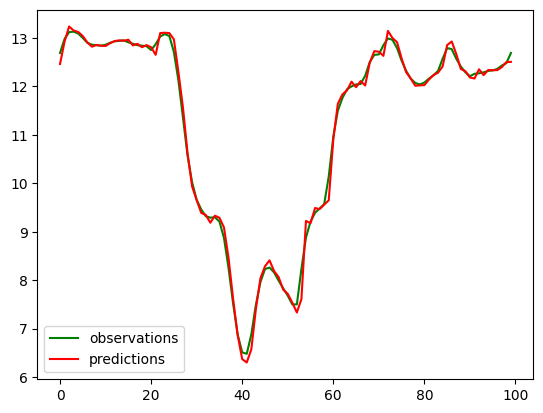

In [5]:
x = range(len(test))
pyplot.plot( test[:100], color='green', label='observations')
pyplot.plot(predictions[:100], color='red', linestyle='-', label='predictions')
pyplot.legend()
pyplot.show()

In [6]:
import numpy as np

epsilon = np.finfo(float).eps

def Wape(y, y_pred):
    """Weighted Average Percentage Error metric in the interval [0; 100]"""
    nominator = np.sum(np.abs(np.subtract(y, y_pred)))
    denominator = np.add(np.sum(np.abs(y)), epsilon)
    wape = np.divide(nominator, denominator)*100.0
    return wape

def nse(y, y_pred):
    return (1-(np.sum((y_pred-y)**2)/np.sum((y-np.mean(y))**2)))

In [7]:
wape = Wape(test.flatten(), predictions)
nsee = nse(test.flatten(), predictions)
print(f'WAPE: {wape}, Nse: {nsee}')

WAPE: 0.5581631765771289, Nse: 0.9978262645388802


In [12]:
x = [1,2,3,4,5,6,7]
[i for i in x if i % 2 == 0]

[2, 4, 6]